In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Funzioni base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix

# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten, ScatterGroup, MatriceConfusione, indice_gini, tasso_errata_classificazione

### Caricamento dei dati

In [38]:
PATH_DATA = './PhonePi/data/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [39]:
DIR

['./PhonePi/data/camminata-alberto',
 './PhonePi/data/camminata-alberto.2',
 './PhonePi/data/camminata-anna',
 './PhonePi/data/camminata-daniele',
 './PhonePi/data/camminata-emanuele',
 './PhonePi/data/camminata-luisa',
 './PhonePi/data/camminata-luisa.2',
 './PhonePi/data/camminata-simone',
 './PhonePi/data/camminata_tasca-alberto',
 './PhonePi/data/camminata_tasca-alberto.2',
 './PhonePi/data/camminata_tasca-daniele',
 './PhonePi/data/camminata_tasca-emanuele',
 './PhonePi/data/camminata_tasca-luisa',
 './PhonePi/data/camminata_tasca-luisa.2',
 './PhonePi/data/camminata_tasca-simone',
 './PhonePi/data/corsa-alberto',
 './PhonePi/data/corsa-anna',
 './PhonePi/data/corsa-daniele',
 './PhonePi/data/corsa-luisa',
 './PhonePi/data/corsa-martina',
 './PhonePi/data/corsa_tasca-alberto',
 './PhonePi/data/corsa_tasca-anna',
 './PhonePi/data/corsa_tasca-daniele',
 './PhonePi/data/corsa_tasca-francesco',
 './PhonePi/data/corsa_tasca-luisa',
 './PhonePi/data/quotidiano-alberto',
 './PhonePi/data

In [40]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|████████████████████████████████████████| 44/44 [00:07<00:00,  4.96it/s]


#### Grafici per esempi

100%|██████████████████████████████████████████| 3/3 [00:11<00:00,  5.11s/it]


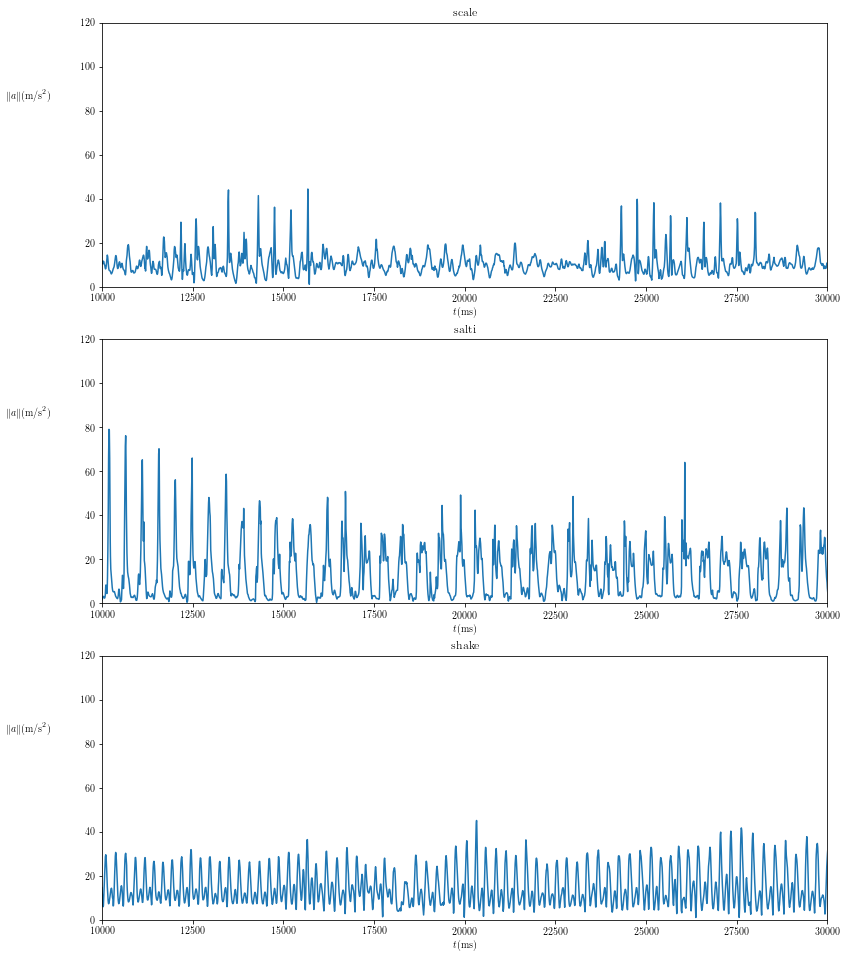

In [55]:
DIRM = ['./PhonePi/data/scale-martina',
        './PhonePi/data/salti-daniele',
        './PhonePi/data/shake-anna']

plt.figure(figsize=(13,5.5*len(DIRM)))
nrow = len(DIRM)
for i in tqdm.tqdm(range(len(DIRM))):
    data = pd.read_csv(DIRM[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120), xlim = (10000,30000))
    ax.set_ylabel(r"$\|a\|(\mathrm{m/s}^2)$", rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.7)
    ax.set_xlabel(r"$t (\mathrm{ms})$")
    ax.set_title((DIRM[i].split("/")[-1]).split("-")[0])
    plt.plot(data["t"],data["a"])
    plt.savefig("./figure/espl.png", dpi=150)    
plt.show()

### Calcolo delle variabili di riassunto

In [42]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

In [43]:
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
Mean = Xnum.mean(axis=1)
Var = Xnum.var(axis=1)
Med = Xnum.median(axis=1)
Min = Xnum.min(axis=1)

In [44]:
espl = pd.concat([maxA, MVDeriv, Mean, Var, Med, Min], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "Var", "Med", "Min"]

In [45]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [49]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

### Analisi esplorativa con `PCA`, `ICA`, `t-SNE`

In [50]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

In [54]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig("./figure/"+title+".png", bbox_inches="tight", dpi=180)

RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002496B650400> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




<Figure size 792x432 with 1 Axes>

### Analisi discriminante lineare e quadratica

In [59]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine="./figure/matrice_confusione_lda")

Accuratezza LDA: 79.2%


RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




<Figure size 432x288 with 2 Axes>

In [60]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine="./figure/matrice_confusione_qda")

Accuratezza QDA: 88.2%


RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




RuntimeError: latex was not able to process the following string:
b'camminata_tasca'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6840 64-bit)
entering extended mode
(C:/Users/zagod/.matplotlib/tex.cache/bd8aaf49e5adff4d194278e61c6a8582.tex
LaTeX2e <2018-04-01> patch level 5
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.clo"))

("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\type1cm\type1cm.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1enc.dfu"))
) ("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\inputenc.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
sty"
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\graphics\keyval.st
y")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.s
ty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.
sty")
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\geometry\geometry.
cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (bd8aaf49e5adff4d194278e61c6a8582.aux)
("C:\Users\zagod\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily camminata_
                                                  tasca}
No pages of output.
Transcript written on bd8aaf49e5adff4d194278e61c6a8582.log.




<Figure size 432x288 with 2 Axes>